# Introducing EventCA
EventCA is a python package that makes event studies with component analysis easy. 
All you need is a dataframe of returns with a 'Log Return' column and a 'Date' column,
as well as a dataframe of events with a 'Date' column. Optionally, this event dataframe can hold event characteristics,
our methodology makes it easy to then run summary statistics on these characteristics.

In [26]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))

from eventca.analysis import construct_event_windows
from eventca.analysis import add_pcs
from eventca.analysis import add_ics
from eventca.visualization import plot_conditional_cumulative_returns
from eventca.visualization import plot_time_series
from eventca.visualization import plot_ca_loadings
from eventca.visualization import plot_conditional_means

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(9)

# Importing Data

This section loads our required datasets:
1. S&P 500 index data with daily price information
2. FOMC meeting dates
3. US recession indicators to add context to our event analysis

EventCA works with two primary inputs: a time series of asset returns and a series of event dates.

Our meeting time-series could have a characteristic in-built, but for now we add on US recession data manually.

In [27]:
spy_df = pd.read_csv('../data/sp500_raw_index_1976-01-01_to_2023-12-31_1D.csv')
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df['Log Return'] = np.log(spy_df['Adj Close']).diff()
spy_df.set_index('Date', inplace=True)
df = pd.read_csv('../data/meeting_time_series.csv')
df['Date'] = pd.to_datetime(df['Date'])
recessions = pd.read_csv('../data/USREC.csv')
recessions['Date'] = pd.to_datetime(recessions['DATE'])
df = pd.merge_asof(df, recessions[['Date', 'USREC']], on='Date', direction='forward')
# A meeting is labeled as a recession if it occurs atleast 1 month before a recession label
df.head()

,Date,USREC
0,1976-03-29,0
1,1976-04-20,0
2,1976-05-18,0
3,1976-06-22,0
4,1976-07-20,0


Here we construct the featured events dataframe by simply passing in the dates of the events we want to study and the returns dataframe.
To note is the min_periods parameter. Market returns have an innovation component, for the purposes of the illustrations below we set this to 8 to remove this innovation, since we are more interested in abnormal returns, but you can set this to None.

## Core EventCA Workflow

EventCA simplifies the event study process with just a few function calls:

1. `construct_event_windows()`: Creates the event study windows around each event date
2. `add_pcs()`: Performs PCA and adds component loadings to the event DataFrame
3. `add_ics()`: Performs ICA and adds component loadings to the event DataFrame

These functions handle all the data preparation, alignment, and analysis in the background, returning ready-to-use results.

In [28]:
featured_events, return_cols = construct_event_windows(event_df = df,
return_df = spy_df,
start_window = -45,
return_window = 45,
min_periods=8)

featured_events, pc_res = add_pcs(event_df = featured_events, return_cols=return_cols, n_pcs=3)

featured_events, ic_res = add_ics(event_df = featured_events, return_cols=return_cols, n_ics=3)

## Visualization Made Easy

EventCA includes a comprehensive set of visualization functions that handle the complexity of plotting event study results:

- `plot_ca_loadings()`: Visualizes component loadings from PCA or ICA
- `plot_conditional_cumulative_returns()`: Groups events by component loading and shows average returns
- `plot_time_series()`: Shows how component loadings evolve over time
- `plot_conditional_means()`: Creates boxplots for comparing component loadings across categories

Each function accepts intuitive parameters and returns a matplotlib figure that can be further customized.

## Component Analysis

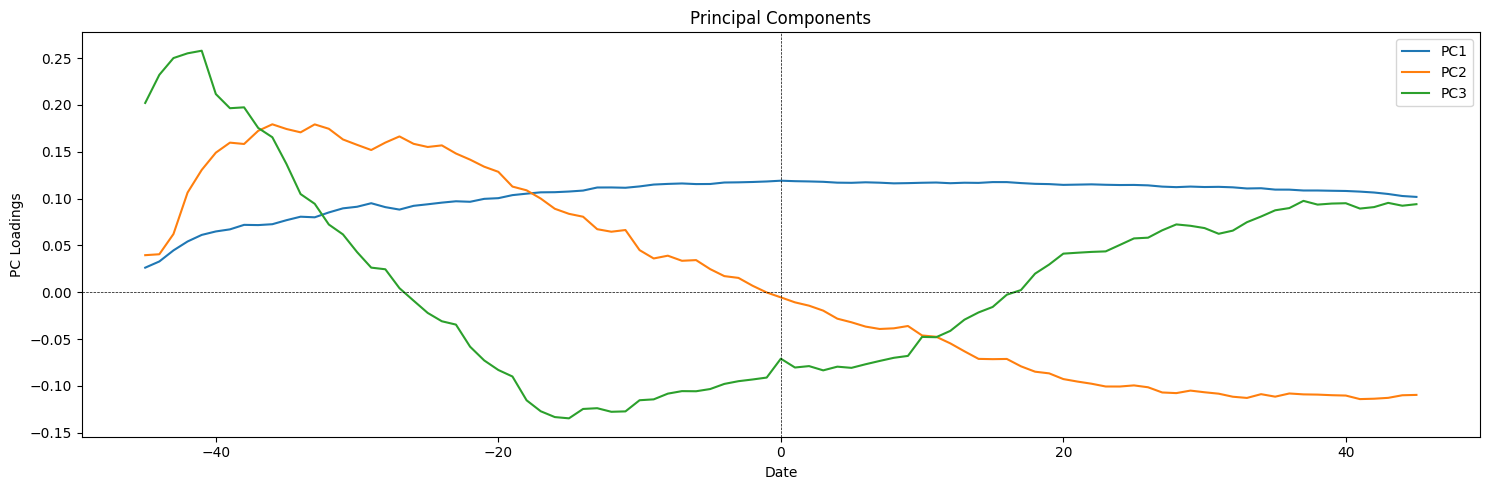

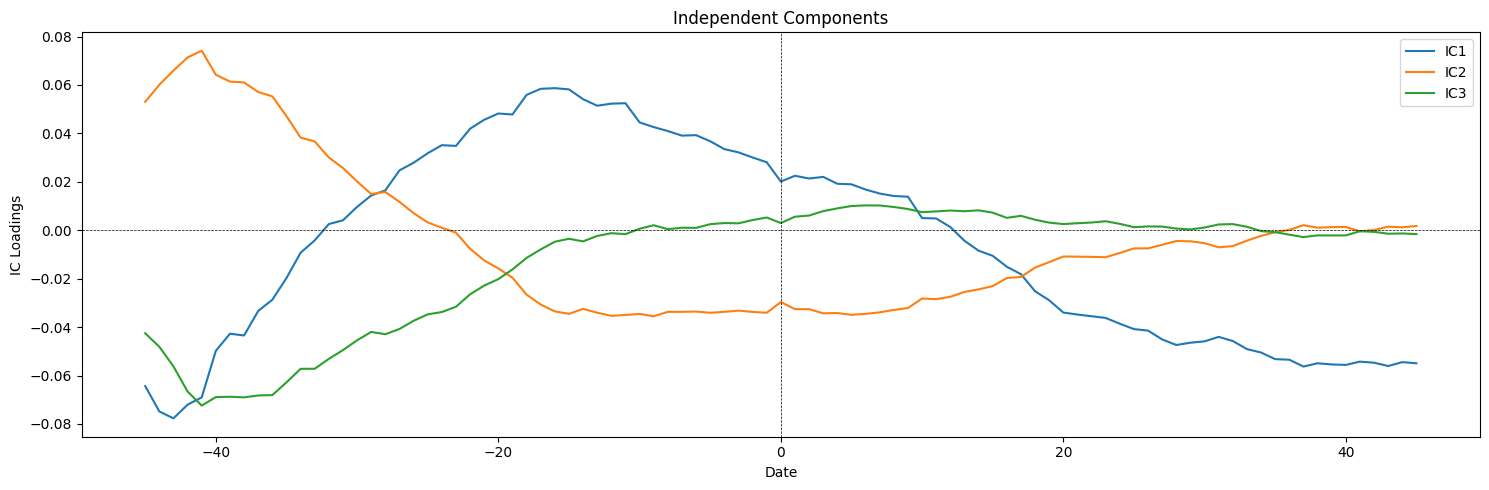

In [29]:
_ = plot_ca_loadings(return_cols, pc_res, title='Principal Components', xlabel='Date', y_label='PC Loadings', figsize=(15, 5), legend=['PC1', 'PC2', 'PC3'],
save_path='../figs/pc_loadings.png')
_ = plot_ca_loadings(return_cols, ic_res, title='Independent Components', xlabel='Date', y_label='IC Loadings', figsize=(15, 5), legend=['IC1', 'IC2', 'IC3'],
save_path='../figs/ic_loadings.png')

Our PCA and ICA methods show us the same profiles explored in 2.0.FOMC_case_study, but the code is now much cleaner.

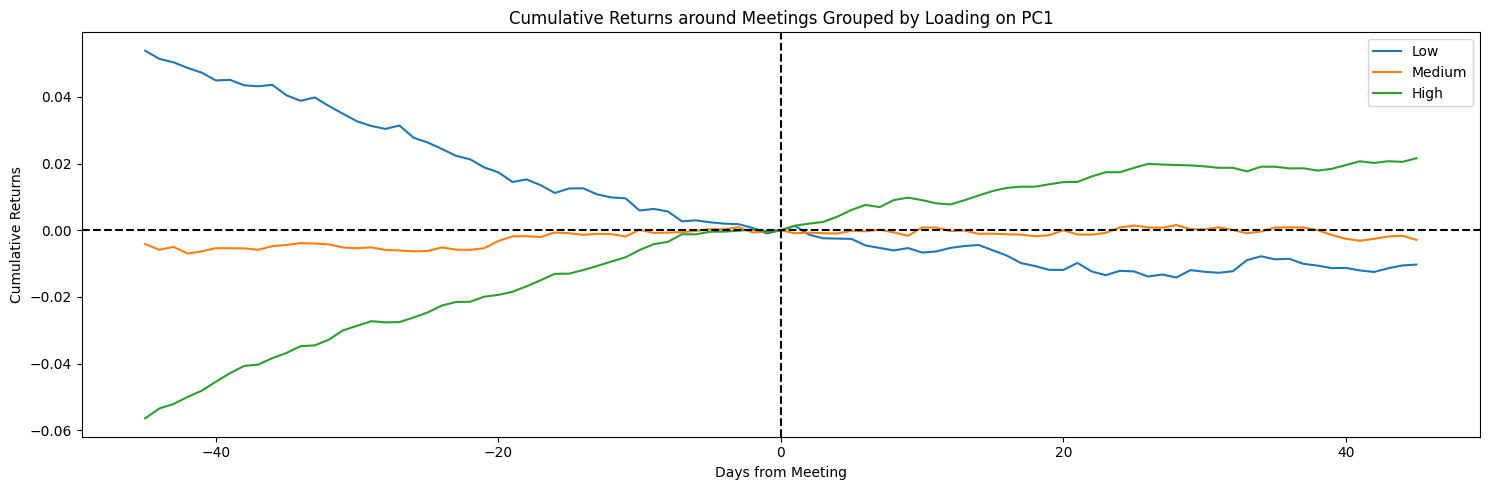

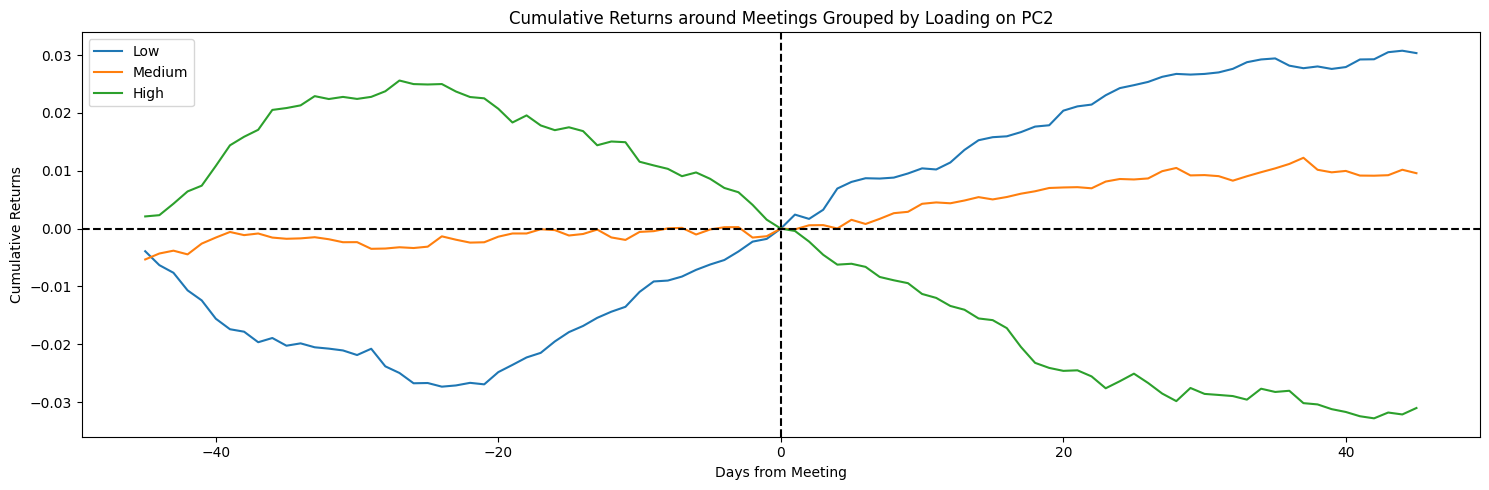

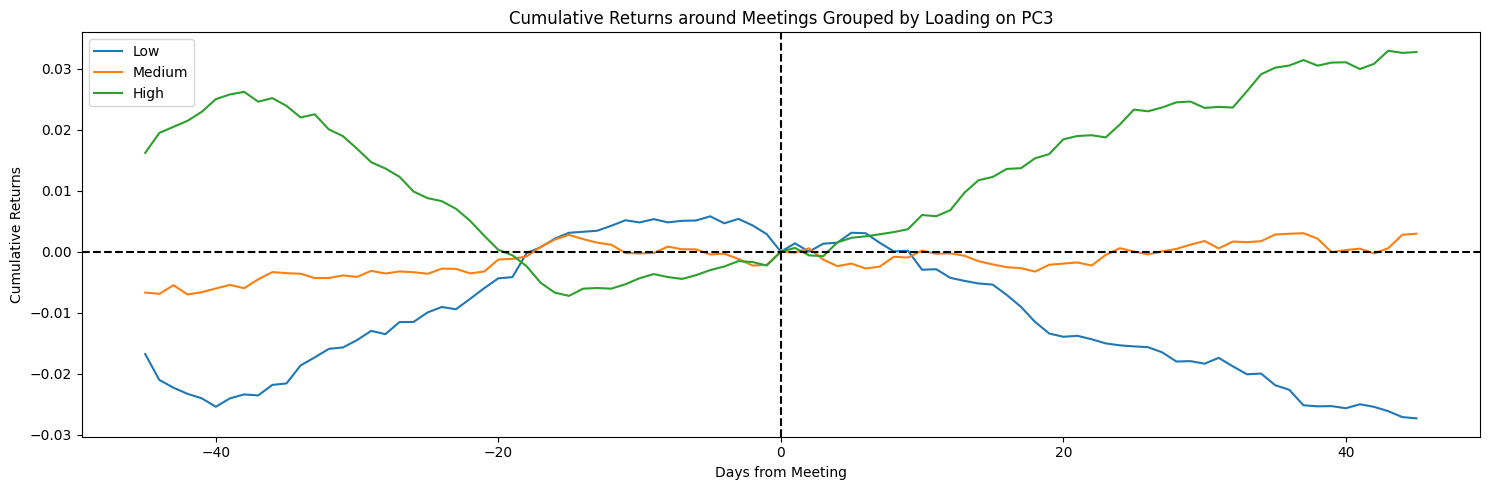

In [30]:
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'PC1', title='Cumulative Returns around Meetings Grouped by Loading on PC1',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/pc1_group_cumulative_returns.png')
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'PC2', title='Cumulative Returns around Meetings Grouped by Loading on PC2',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/pc2_group_cumulative_returns.png')
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'PC3', title='Cumulative Returns around Meetings Grouped by Loading on PC3',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/pc3_group_cumulative_returns.png')

## Time Series Analysis

Tracing component loadings over time can reveal important shifts in market behavior. EventCA makes this straightforward with the `plot_time_series()` function, which handles:

- Option to display absolute values to focus on component strength rather than direction
- Automatic rolling window smoothing for clearer trend visualization
- Proper date handling and formatting
- Consistent styling and presentation

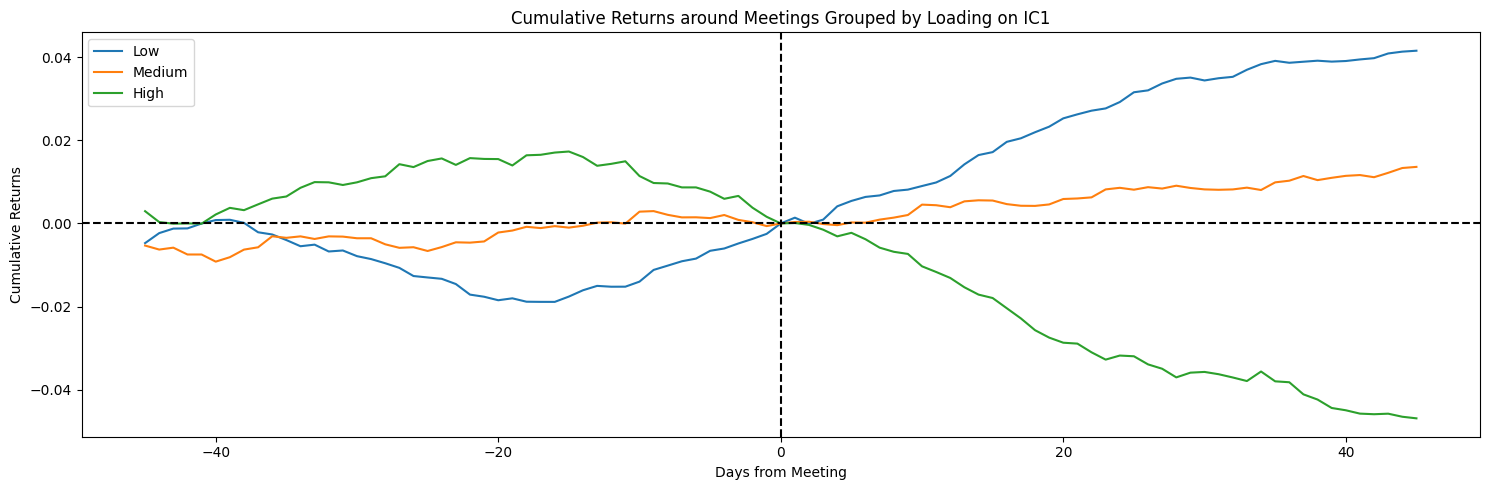

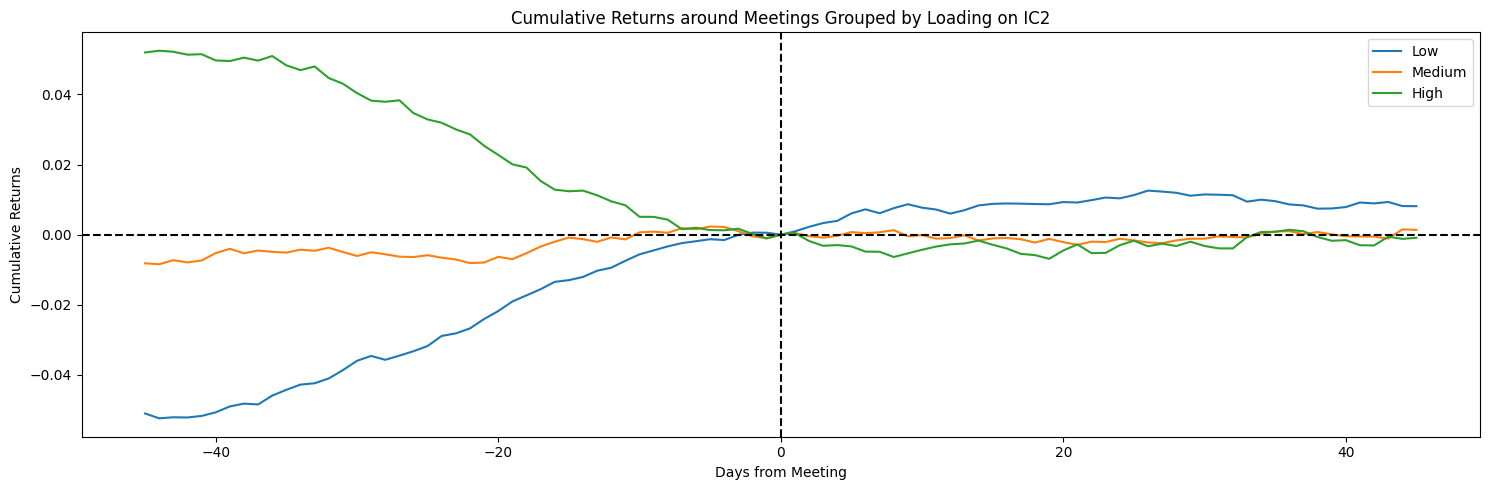

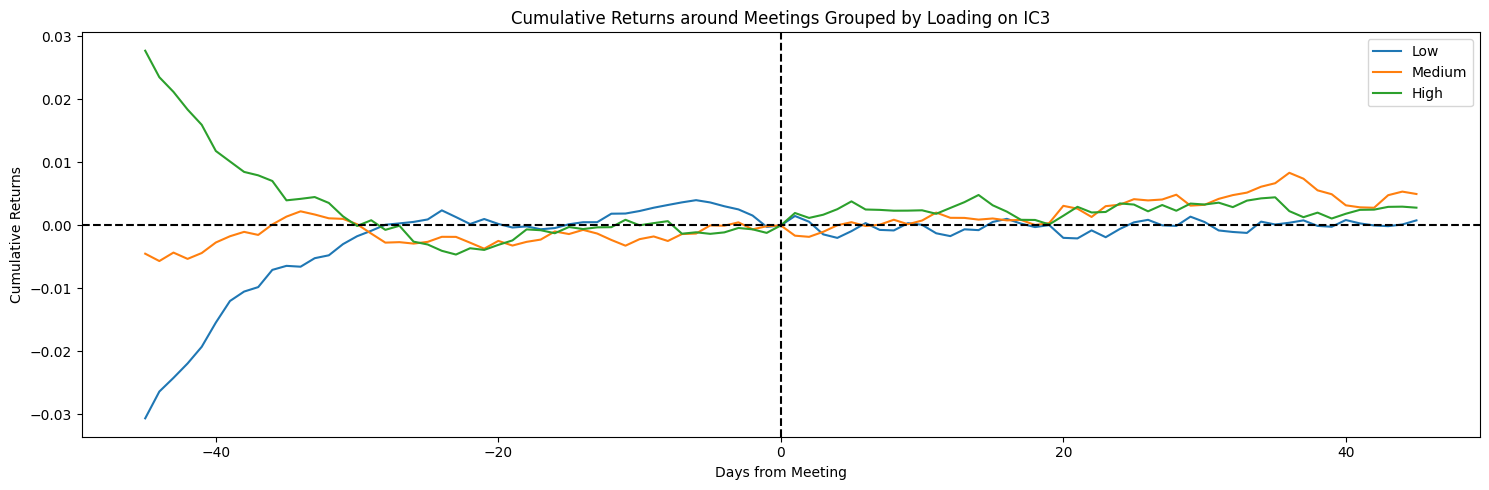

In [31]:
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'IC1', title='Cumulative Returns around Meetings Grouped by Loading on IC1',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/ic1_group_cumulative_returns.png')
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'IC2', title='Cumulative Returns around Meetings Grouped by Loading on IC2',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/ic2_group_cumulative_returns.png')
_ = plot_conditional_cumulative_returns(featured_events, return_cols, 'IC3', title='Cumulative Returns around Meetings Grouped by Loading on IC3',
                                    xlabel='Days from Meeting', ylabel='Cumulative Returns', figsize=(15, 5), save_path='../figs/ic3_group_cumulative_returns.png')

## Event Characteristics Analysis

EventCA makes it easy to analyze how component loadings relate to event characteristics (like whether an FOMC meeting occurred during a recession). The `plot_conditional_means()` function:

- Automatically creates boxplots grouped by the specified characteristic
- Properly formats labels and axes
- Handles all the data reshaping needed for boxplot creation

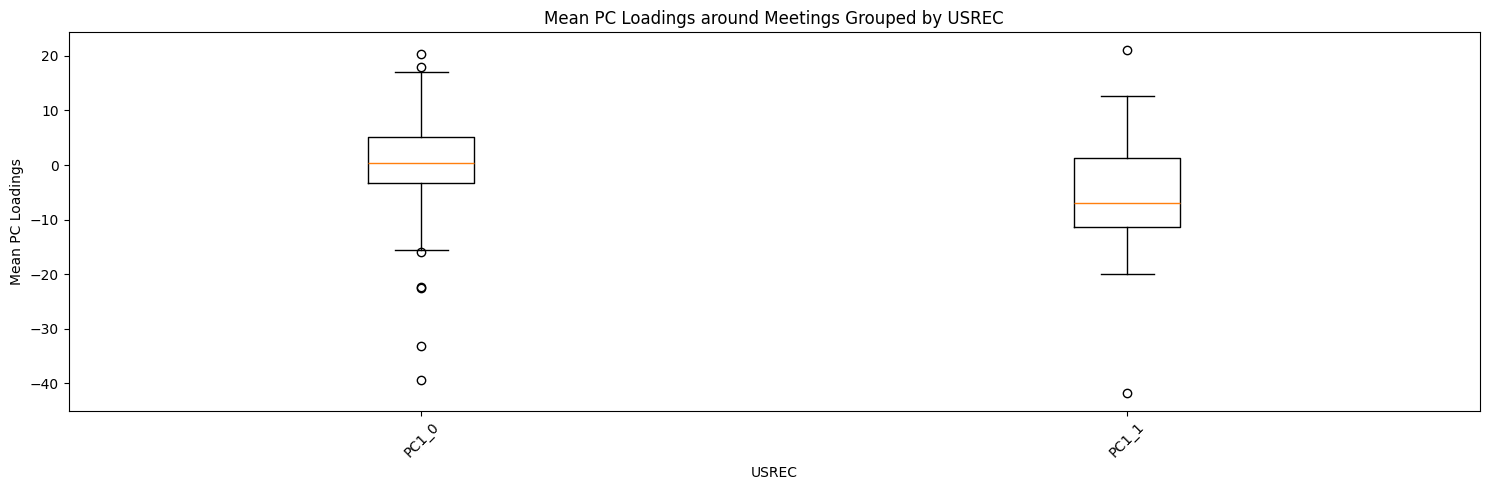

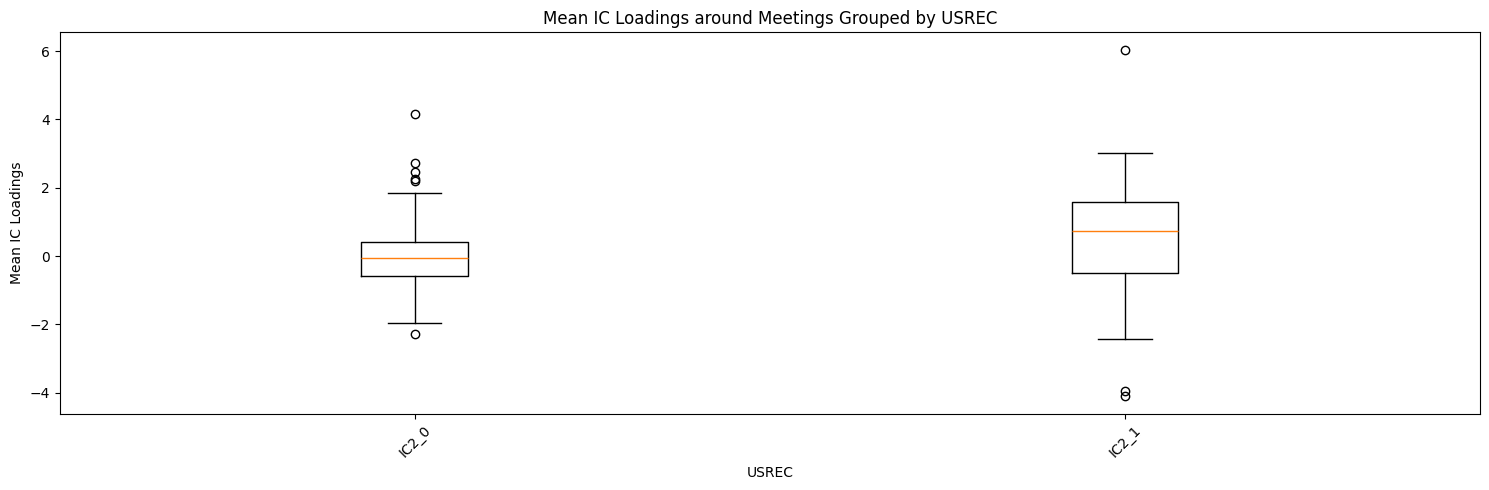

In [32]:
# Mean PC and IC loadings based on USREC (Boxplot)
_ = plot_conditional_means(event_df=featured_events,
                        return_cols=return_cols,group_col='USREC',
                        y_cols = ['PC1'], title='Mean PC Loadings around Meetings Grouped by USREC',
                        xlabel='USREC', ylabel='Mean PC Loadings', figsize=(15, 5), save_path='../figs/pc_usrec_boxplot.png')
_ = plot_conditional_means(event_df=featured_events,
                        return_cols=return_cols,group_col='USREC',
                        y_cols = ['IC2'], title='Mean IC Loadings around Meetings Grouped by USREC',
                        xlabel='USREC', ylabel='Mean IC Loadings', figsize=(15, 5), save_path='../figs/ic_usrec_boxplot.png')

## Extending Visualizations

All EventCA visualization functions return matplotlib figures that can be extended with additional elements. Here, we demonstrate:

1. Creating a base plot with `plot_time_series()`
2. Adding highlights for specific events (top/bottom quartile PC1 events)
3. Customizing the legend and saving the enhanced visualization

This extensibility allows you to create publication-quality visualizations without sacrificing the convenience of EventCA's built-in plotting functions.

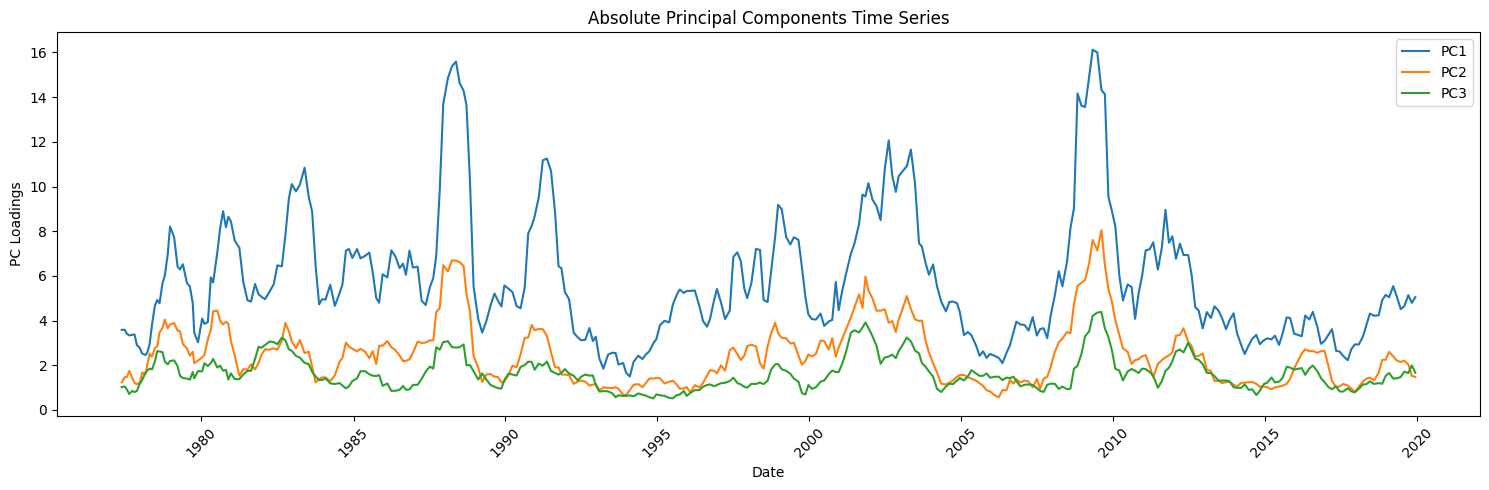

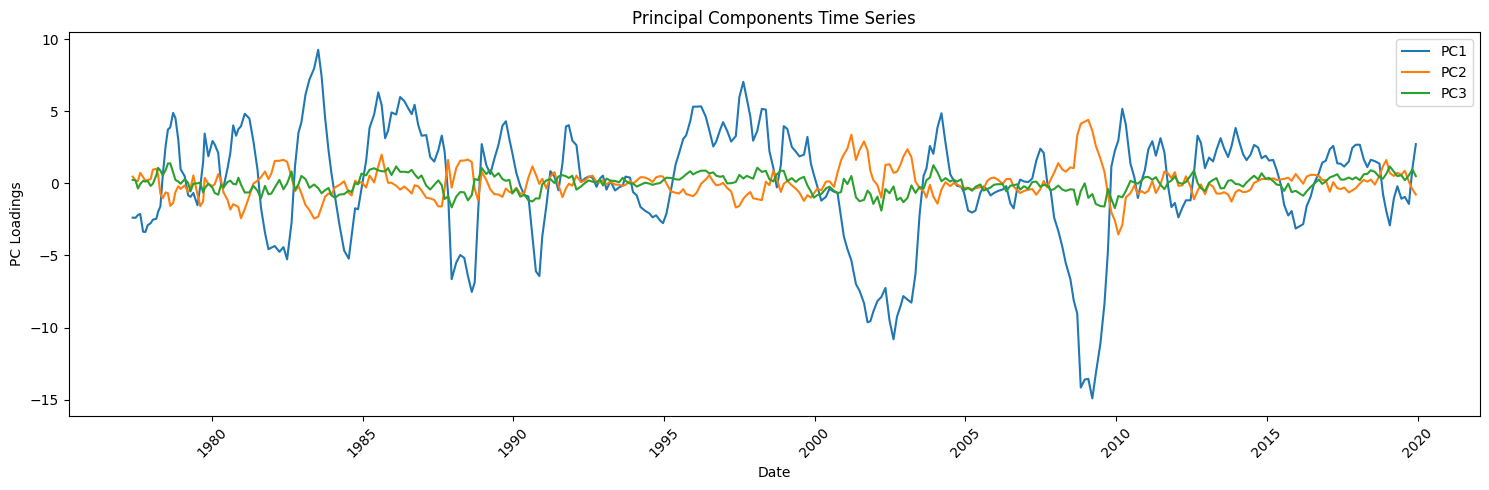

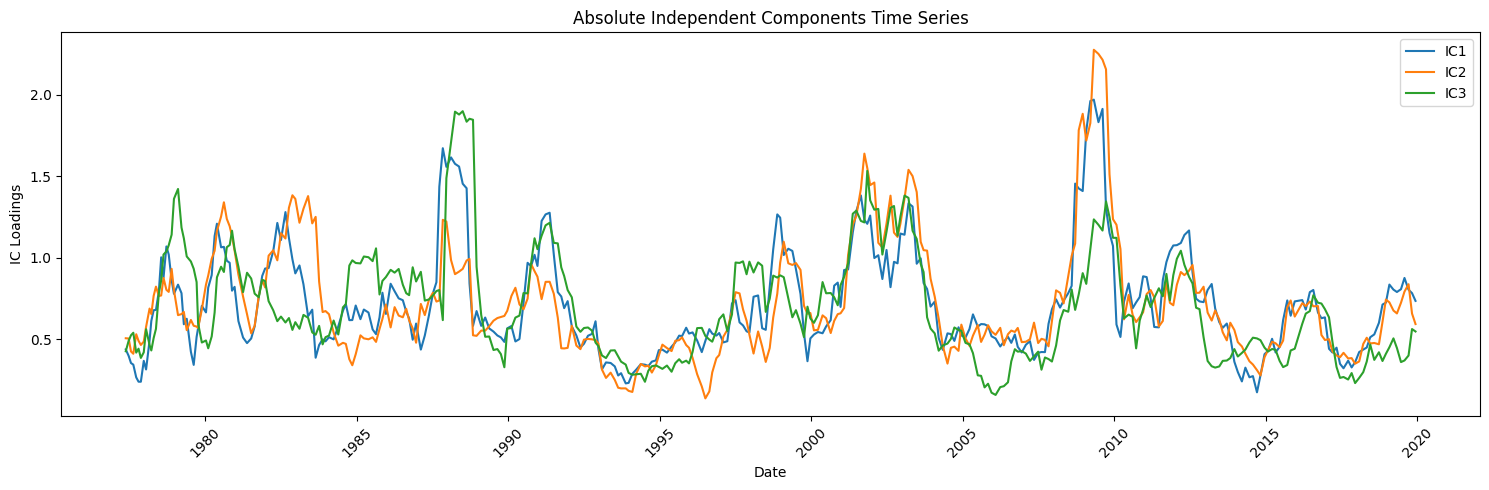

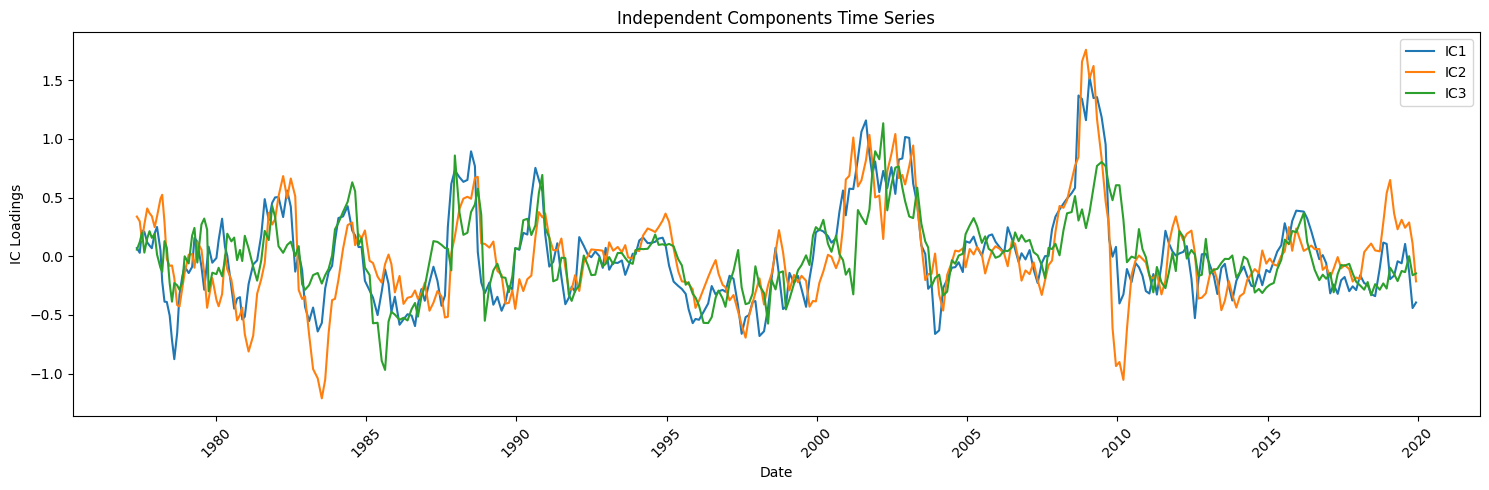

In [33]:
_ = plot_time_series(event_df=featured_events,
                date_col='Date',
                ts_cols=['PC1', 'PC2', 'PC3'],
                title='Absolute Principal Components Time Series',
                xlabel='Date', ylabel='PC Loadings',
                figsize=(15, 5), 
                rolling_window=8,
                abs = True,
                save_path='../figs/pc_time_series_abs.png')

_ = plot_time_series(event_df=featured_events,
                date_col='Date',
                ts_cols=['PC1', 'PC2', 'PC3'],
                title='Principal Components Time Series',
                xlabel='Date', ylabel='PC Loadings',
                figsize=(15, 5), 
                rolling_window=8,
                save_path='../figs/pc_time_series.png')

_ = plot_time_series(event_df=featured_events,
                date_col='Date',
                ts_cols=['IC1', 'IC2', 'IC3'],
                title='Absolute Independent Components Time Series',
                xlabel='Date', ylabel='IC Loadings',
                figsize=(15, 5), 
                rolling_window=8,
                abs = True,
                save_path='../figs/ic_time_series_abs.png')

_ = plot_time_series(event_df=featured_events,
                date_col='Date',
                ts_cols=['IC1', 'IC2', 'IC3'],
                title='Independent Components Time Series',
                xlabel='Date', ylabel='IC Loadings',
                figsize=(15, 5), 
                rolling_window=8,
                save_path='../figs/ic_time_series.png')

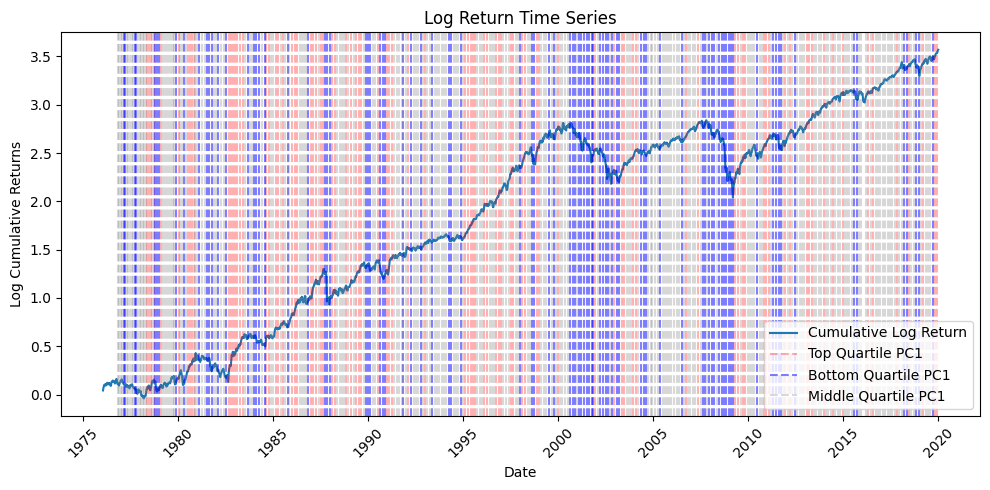

In [38]:
# Compute cumulative log return
spy_df['Cumulative Log Return'] = spy_df['Log Return'].cumsum()

# Plot base time series
fig = plot_time_series(
    event_df=spy_df[spy_df.index < '2020-01-01'].reset_index(),
    date_col='Date',
    ts_cols=['Cumulative Log Return'],
    title='Log Return Time Series',
    xlabel='Date', ylabel='Log Cumulative Returns',
    figsize=(10, 5), 
    rolling_window=8,
    save_path='../figs/log_return_time_series.png'
)

# Get top and bottom quartiles of PC1
upper_tercile = featured_events['PC1'].quantile(0.75)
lower_tercile = featured_events['PC1'].quantile(0.25)

# Highlight PC1 extremes
top_pc1_dates = featured_events[featured_events['PC1'] >= upper_tercile]['Date']
bottom_pc1_dates = featured_events[featured_events['PC1'] <= lower_tercile]['Date']
middle_pc1_dates = featured_events[(featured_events['PC1'] < upper_tercile) & (featured_events['PC1'] > lower_tercile)]['Date']

# Add labels only for the first line so they appear once in the legend
for i, date in enumerate(top_pc1_dates):
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.3, label='Top Quartile PC1' if i == 0 else "")
for i, date in enumerate(bottom_pc1_dates):
    plt.axvline(x=date, color='blue', linestyle='--', alpha=0.5, label='Bottom Quartile PC1' if i == 0 else "")
for i, date in enumerate(middle_pc1_dates):
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.3, label='Middle Quartile PC1' if i == 0 else "")
# Show legend
plt.legend()

# Save and display
plt.savefig('../figs/log_return_time_series_with_pc1_highlighted.png')
plt.show()

## Integrating with External Data

EventCA makes it simple to incorporate external data like recession indicators. Here, we demonstrate:

1. Using the same base plot created with `plot_time_series()`
2. Adding recession shading based on NBER recession dates

This ability to layer additional context on EventCA visualizations enhances the interpretability of your analysis.

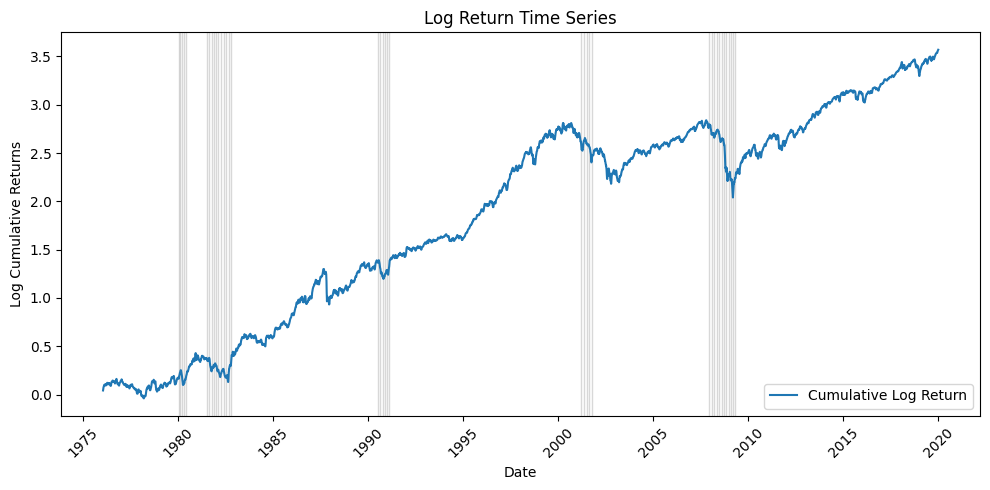

In [35]:
# Plot any base time series
fig = plot_time_series(
    event_df=spy_df[spy_df.index < '2020-01-01'].reset_index(),
    date_col='Date',
    ts_cols=['Cumulative Log Return'],
    title='Log Return Time Series',
    xlabel='Date', ylabel='Log Cumulative Returns',
    figsize=(10, 5), 
    rolling_window=8,
    save_path='../figs/log_return_time_series.png'
)

# Plot grey spans for each contiguous recession period
recession_dates = featured_events[featured_events['USREC'] == 1]['Date'].sort_values().reset_index(drop=True)
if not recession_dates.empty:
    start = recession_dates.iloc[0]
    for i in range(1, len(recession_dates)):
        current = recession_dates.iloc[i]
        previous = recession_dates.iloc[i - 1]
        if (current - previous).days > 1:
            plt.axvspan(start, previous, color='grey', alpha=0.3, label='Recession' if i == 1 else "")
            start = current
    # Close the last span
    plt.axvspan(start, recession_dates.iloc[-1], color='grey', alpha=0.3, label='Recession' if len(recession_dates) == 1 else "")

## Conclusion

EventCA provides a streamlined, flexible framework for event studies using component analysis. Key advantages include:

- **Simplicity**: Just a few function calls to perform complex analysis
- **Flexibility**: Works with any type of return data and event dates
- **Extensibility**: All visualization functions return customizable matplotlib figures
- **Integration**: Easy to combine with external data sources for richer analysis

By abstracting away the implementation details, EventCA lets you focus on interpreting results and gaining insights rather than wrestling with code. The package handles the entire workflow from data preparation to visualization, making sophisticated event studies accessible to researchers and practitioners alike.